In [74]:
import pandas as pd
import numpy as np
from configparser import ConfigParser
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import unidecode
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [75]:
# establish sql engine connection
parser = ConfigParser()
parser.read('nb.ini')
conn_string = parser.get('my_db', 'conn_string')
engine = create_engine(conn_string)

In [76]:
# fetch statcast data from postgresql database

sql1 = '''
    SELECT *
    FROM statcast_2019
'''

sc_19 = pd.read_sql_query(sql1, engine)

sql2 = '''
    SELECT *
    FROM statcast_2020
'''

sc_20 = pd.read_sql_query(sql2, engine)

sql3 = '''
    SELECT *
    FROM statcast_2021
'''

sc_21 = pd.read_sql_query(sql3, engine)

In [77]:
# set relevant columns, concatenate 2019 through 2021 data

cols = ['player_name', 'pitch_type', 'game_date', 'release_speed', 'release_pos_x', 
         'release_pos_y', 'release_pos_z', 'release_spin_rate', 'pfx_x', 'pfx_z', 'plate_z',
         'vy0', 'ax', 'az', 'effective_speed', 'pitch_name', 'spin_axis']

sc_19_ft = sc_19[cols]
sc_20_ft = sc_20[cols]
sc_21_ft = sc_21[cols]

sc_ft = pd.concat([sc_19_ft, sc_20_ft, sc_21_ft])

print(sc_ft.shape)

(1732051, 17)


In [78]:
sc_ft.head()

,player_name,pitch_type,game_date,release_speed,release_pos_x,release_pos_y,release_pos_z,release_spin_rate,pfx_x,pfx_z,plate_z,vy0,ax,az,effective_speed,pitch_name,spin_axis
0,"Hudson, Daniel",SL,2019-10-30,87.9,-2.65,54.42,5.50,2461.0,0.02,0.21,1.03,-127.797998,-1.384471,-29.091156,87.8,Slider,175.0
1,"Hudson, Daniel",FF,2019-10-30,95.9,-2.77,54.83,5.52,2572.0,-0.57,1.52,1.92,-139.212420,-8.940442,-11.563514,94.4,4-Seam Fastball,201.0
2,"Hudson, Daniel",FF,2019-10-30,96.5,-2.68,54.55,5.42,2637.0,-0.66,1.40,1.35,-139.703293,-11.485524,-12.442450,95.3,4-Seam Fastball,205.0
3,"Hudson, Daniel",FF,2019-10-30,96.0,-2.65,54.60,5.55,2598.0,-0.81,1.50,2.05,-139.133193,-12.790017,-11.667275,94.9,4-Seam Fastball,208.0
4,"Hudson, Daniel",SL,2019-10-30,86.7,-2.73,54.28,5.59,2598.0,-0.05,0.47,2.17,-126.044028,-2.223969,-26.826688,87.0,Slider,186.0


In [79]:
# remove accents from names for standardization

sc_ft['player_name'] = sc_ft['player_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [80]:
# how many unique pitchers in the dataset

sc_ft['player_name'].nunique()

1255

### Data Exploration

In [81]:
# identify null percentages

sc_ft.isnull().sum()/len(sc_ft)

player_name          0.000000
pitch_type           0.003313
game_date            0.000000
release_speed        0.004220
release_pos_x        0.004334
release_pos_y        0.004334
release_pos_z        0.004334
release_spin_rate    0.013228
pfx_x                0.004212
pfx_z                0.004212
plate_z              0.004212
vy0                  0.004212
ax                   0.004212
az                   0.004212
effective_speed      0.002938
pitch_name           0.003313
spin_axis            0.005926
dtype: float64

In [82]:
# drop all nulls - won't lose anything

sc_ft = sc_ft.dropna()

In [83]:
# confirm data types

sc_ft.dtypes

player_name           object
pitch_type            object
game_date             object
release_speed        float64
release_pos_x        float64
release_pos_y        float64
release_pos_z        float64
release_spin_rate    float64
pfx_x                float64
pfx_z                float64
plate_z              float64
vy0                  float64
ax                   float64
az                   float64
effective_speed      float64
pitch_name            object
spin_axis            float64
dtype: object

In [84]:
# convert game date to pd.datetime type

sc_ft['game_date'] =  pd.to_datetime(sc_ft['game_date'])

In [85]:
# what does our target variable look like? 

print(sc_ft['pitch_type'].unique())
print(sc_ft['pitch_name'].unique())

['SL' 'FF' 'CH' 'CU' 'SI' 'FT' 'FC' 'EP' 'KC' 'FS' 'CS' 'FA' 'FO' 'KN'
 'SC']
['Slider' '4-Seam Fastball' 'Changeup' 'Curveball' 'Sinker'
 '2-Seam Fastball' 'Cutter' 'Eephus' 'Knuckle Curve' 'Split-Finger'
 'Fastball' 'Forkball' 'Knuckleball' 'Screwball']


In [86]:
sc_ft['pitch_type'].value_counts()

FF    610981
SL    306573
SI    213260
CH    192314
CU    149071
FC    113027
FT     59176
KC     36536
FS     26078
FA      1217
CS       616
EP       123
KN       106
FO        35
SC         1
Name: pitch_type, dtype: int64

Cleanup:

FA is a generic fastball category that statcast uses as a catch all category and instances can be dropped from the training set. CS is an unknown category, EP is an 'ephus' pitch which isn't important to the model. KN, and SC pitch types can be dropped. Since FT has been dropped from Statcast pitch types in 2021, we will not use it to train our model, it will be dropped.

CH and FO represent change ups and forkballs, respectively. These two pitches have very similar action and can be lumped into the same category. 

In [87]:
# drop instances with FA, CS, EP, KN, and SC

drop_list = ['FA', 'CS', 'EP', 'KN', 'SC', 'FT']

sc_ft = sc_ft[sc_ft.pitch_type.isin(drop_list) == False]

In [88]:
# Applying the condition - wrap into function
sc_ft['pitch_type'].mask(sc_ft['pitch_type'] == 'FO', 'CH', inplace=True) 
sc_ft['pitch_type'].mask(sc_ft['pitch_type']== 'KC', 'CU', inplace=True)


In [89]:
sc_ft['pitch_type'].value_counts()

FF    610981
SL    306573
SI    213260
CH    192349
CU    185607
FC    113027
FS     26078
Name: pitch_type, dtype: int64

In [90]:
# split the data into train/test
# statcast data from 2019 and 2020 seasons will be used for training
# statcast data from 2021 will be used as our test set

X_train = sc_ft.loc[sc_ft['game_date']<'2021-01-01'].drop(["pitch_type", "pitch_name", "game_date", "player_name"], axis=1)
X_test = sc_ft.loc[sc_ft['game_date']>'2021-01-01'].drop(["pitch_type", "pitch_name", "game_date", "player_name"], axis=1)
y_train = sc_ft.loc[sc_ft['game_date']<'2021-01-01']['pitch_type'].values.flatten()
y_test = sc_ft.loc[sc_ft['game_date']>'2021-01-01']['pitch_type'].values.flatten()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(931760, 13)
(716115, 13)
(931760,)
(716115,)


In [91]:
# create pipeline with standard scaler and classifier steps
dt_clf = Pipeline(steps=[('scaler', StandardScaler()),
                         ('classifier', DecisionTreeClassifier())])

In [92]:
# set hyperparameter grid for tuning

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [2, 5, 8]

params = dict(classifier__criterion = criterion,
              classifier__splitter = splitter,
              classifier__max_depth = max_depth)

In [93]:
# fit the model

dt_clf_GS = GridSearchCV(dt_clf, params)

dt_clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [2, 5, 8],
                         'classifier__splitter': ['best', 'random']})

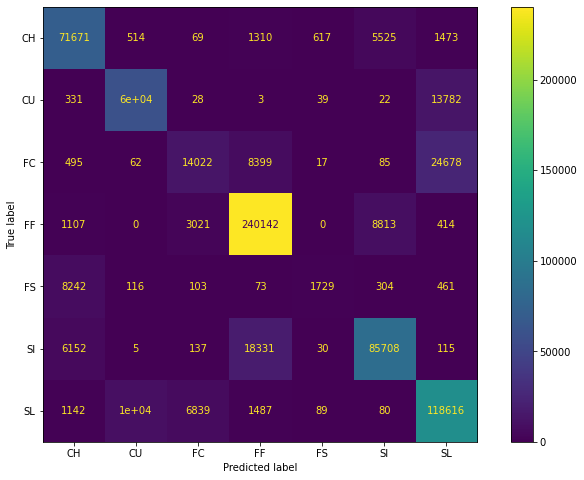

In [94]:
y_pred = dt_clf_GS.best_estimator_.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=dt_clf_GS.best_estimator_.classes_)
cmp.plot(ax=ax)

plt.show()

In [95]:
print(classification_report(y_test, y_pred, target_names=dt_clf_GS.best_estimator_.classes_))

              precision    recall  f1-score   support

          CH       0.80      0.88      0.84     81179
          CU       0.85      0.81      0.83     73821
          FC       0.58      0.29      0.39     47758
          FF       0.89      0.95      0.92    253497
          FS       0.69      0.16      0.26     11028
          SI       0.85      0.78      0.81    110478
          SL       0.74      0.86      0.80    138354

    accuracy                           0.83    716115
   macro avg       0.77      0.67      0.69    716115
weighted avg       0.82      0.83      0.81    716115



Overall, this catch all model performs fairly well all things considered. It particularly struggles with the cut fastball, which is to be expected given the similarity in movement in 3d space. It also struggles with the sinker/split finger (FS), mistaking it for a change up in most error cases. 

Perhaps, a better use case for a pitch classifier would be to parallelize model development per pitcher. This way, each model can learn from each player individually and provide more consistent and accurate results. For "cold start" situations, such as a rookie, all MLB pitchers could be clustered based on their individual statcast data and models be built based on each cold start cluster. This way, we can still predict pitch types even without any historical data. Although, I'm willing to bet the MLB has statcast data on players ascending through the minor leagues.

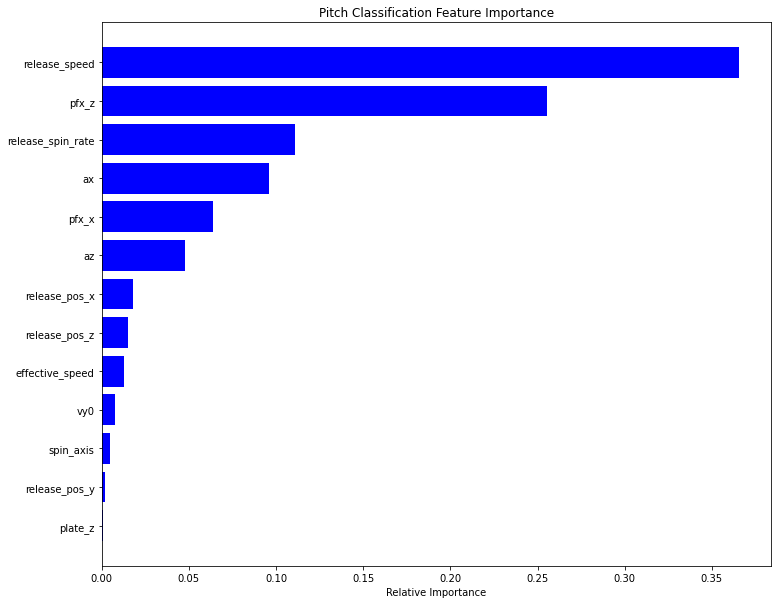

In [96]:
features = X_train.columns.to_list()
importances = dt_clf_GS.best_estimator_._final_estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,10))
plt.title('Pitch Classification Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


The model is behaving as I thought it would. It makes a lot of sense that the top 3 predictors are release speed, pfx_z and spin rate. Release speed and spin rate are self explanatory in their definitions, but pfx_z makes sense as this represents whether a pitch has front or backspin. Any fastball is going to have backspin whereas breaking pitches will have front spin. The model does well in differentiating between the two in predicting the pitch type. 

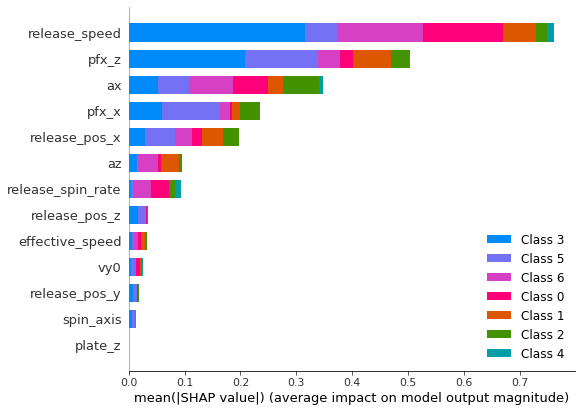

In [97]:
import shap
shap_values = shap.TreeExplainer(dt_clf_GS.best_estimator_._final_estimator).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")